In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium

In [2]:
df = pd.read_csv('citibike-trips.csv')

In [3]:
df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,2319,2016-03-09 13:08:21,2016-03-09 13:47:01,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,-74.017134,23062,Subscriber,1972.0,male,NaN
1,313,2015-07-09 15:42:30,2015-07-09 15:47:44,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,-73.982912,16909,Subscriber,1968.0,female,NaN
2,798,2017-04-20 18:43:59,2017-04-20 18:57:17,520,W 52 St & 5 Ave,40.759923,-73.976485,3258,W 27 St & 10 Ave,40.750182,-74.002184,15555,Subscriber,1991.0,male,NaN
3,3100,2017-04-23 15:23:46,2017-04-23 16:15:26,520,W 52 St & 5 Ave,40.759923,-73.976485,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,20648,Customer,NaN,unknown,NaN
4,906,2016-01-11 18:32:33,2016-01-11 18:47:39,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,-73.980931,15614,Subscriber,1961.0,male,NaN


In [4]:
#Just some initial cleaning: Split the starttime and date so that they appear in two different columns.
df[['start_date', 'start_time']] = df['starttime'].str.split(' ', expand=True)
df[['stop_date', 'stop_time']] = df['stoptime'].str.split(' ', expand=True)

In [5]:
#No need for the original start and stop times, every value in the customer_plan column appears to be blank.
df = df.drop(['starttime', 'stoptime', 'customer_plan'], axis=1)

In [6]:
#Convert the 2 new columns to datetime objects
df['start_date'] = pd.to_datetime(df['start_date'])
df['stop_date'] = pd.to_datetime(df['stop_date'])

In [7]:
df.isnull().sum()

tripduration                   0
start_station_id               0
start_station_name             0
start_station_latitude         0
start_station_longitude        0
end_station_id                 0
end_station_name               0
end_station_latitude           0
end_station_longitude          0
bikeid                         0
usertype                       0
birth_year                 55975
gender                         0
start_date                     0
start_time                     0
stop_date                      0
stop_time                      0
dtype: int64

Data Question to explore: From which stations are the longest trips taken? How can we use that information to guide station replenishing. 

Identify the top stations with the highest average trip durations or the stations that consistently have longer trips compared to others.

Side note: I can perform a time-series-analysis to see how useage has changed between 2013 and 2017 and even if there are trends or seasonality in the data from citi bike. 

In [8]:
#Quick view of the usage for fun =] 

# Set the 'start_date' column as the DataFrame index
df.set_index('start_date', inplace=True)

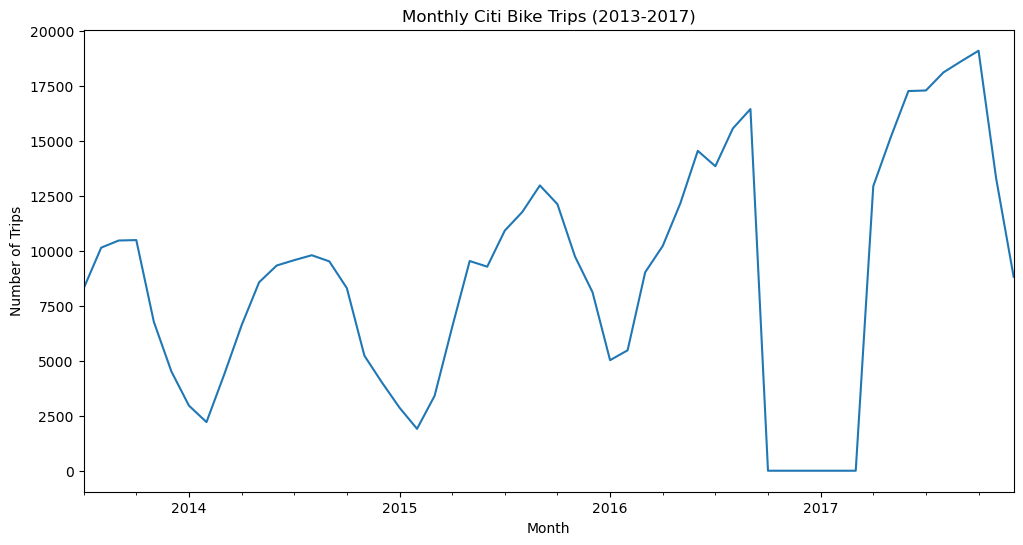

In [9]:
# Resample the data by month and calculate the total number of trips
monthly_trips = df.resample('M').size()

# Plot the monthly trips over time
monthly_trips.plot(figsize=(12, 6))
plt.title('Monthly Citi Bike Trips (2013-2017)')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.show()

Hypothesis: Stations near parks, waterfront, or recreational areas will have longer average ride durations and more rides overall compared to stations in densely populated urban centers.

In [10]:
#Start by grouping the stations by ID to help calculate the average duration
grouped_data = df.groupby('start_station_id')

In [11]:
#Find the average trip duration by station ID
avg_duration_by_station = grouped_data['tripduration'].mean()

In [12]:
#after finding the average trip duration by station we sort the values in decending order
avg_duration_by_station = avg_duration_by_station.sort_values(ascending=False)

In [13]:
avg_duration_by_station.head(10)

start_station_id
3342    23362.028571
3395    13003.153846
3077     9616.151111
3404     6348.380952
3054     5733.574468
3179     5258.547619
3317     4577.086207
3423     4313.950249
3068     3978.331034
3041     3915.816901
Name: tripduration, dtype: float64

In [14]:
avg_duration_by_station.tail(10)

start_station_id
3594    385.000000
3586    381.000000
3617    376.461538
3612    370.250000
3523    337.666667
3040    319.000000
3575    252.000000
3513    238.500000
3625    227.666667
3239    125.000000
Name: tripduration, dtype: float64

In [15]:
top_stations = avg_duration_by_station.head(30).index

bottom_stations = avg_duration_by_station.tail(30).index

In [16]:
top_stations_df = top_stations.to_frame(name='start_station_id').reset_index(drop=True)

bottom_stations_df = bottom_stations.to_frame(name='start_station_id').reset_index(drop=True)

selected_stations_df = pd.concat([top_stations_df, bottom_stations_df])

In [17]:
top_stations_df

,start_station_id
0,3342
1,3395
2,3077
3,3404
4,3054
5,3179
6,3317
7,3423
8,3068
9,3041


In [18]:
# Get the station details for the selected stations
selected_station_details = df[df['start_station_id'].isin(selected_stations_df['start_station_id'])].groupby(['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']).first().reset_index()

In [19]:
selected_station_details.head()

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,tripduration,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_time,stop_date,stop_time
0,82,St James Pl & Pearl St,40.711174,-74.000165,391,151,Cleveland Pl & Spring St,40.721816,-73.997203,17627,Subscriber,1989.0,male,09:44:14,2014-12-29,09:50:45
1,271,Ashland Pl & Hanson Pl,40.685282,-73.978058,312,275,Washington Ave & Greene Ave,40.686501,-73.965633,18700,Subscriber,1977.0,male,19:58:36,2014-10-27,20:03:48
2,289,Monroe St & Classon Ave,40.684568,-73.958811,128,344,Monroe St & Bedford Ave,40.685144,-73.953809,21047,Subscriber,1972.0,male,16:52:04,2014-09-18,16:54:12
3,372,Franklin Ave & Myrtle Ave,40.694528,-73.958089,240,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,16797,Subscriber,1973.0,male,13:10:55,2016-02-01,13:14:56
4,372,Franklin Ave & Myrtle Ave,40.694546,-73.958014,468,262,Washington Park,40.691782,-73.973730,20186,Subscriber,1991.0,male,12:52:18,2017-08-22,13:00:06


In [70]:
#Creating a map of NYC to plot points of stations
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

In [71]:
for idx, row in selected_station_details.iterrows():
    station_id = row['start_station_id']
    station_name = row['start_station_name']
    latitude = row['start_station_latitude']
    longitude = row['start_station_longitude']
    
    if station_id in top_stations:
        color = 'red'
        icon = folium.Icon(color=color, icon='star')
        popup_text = f"Station ID: {station_id}<br>Station Name: {station_name}<br>Most Used Station"
    else:
        color = 'blue'
        icon = folium.Icon(color=color, icon='info-sign')
        popup_text = f"Station ID: {station_id}<br>Station Name: {station_name}<br>Least Used Station"
    
    folium.Marker(location=[latitude, longitude], popup=popup_text, icon=icon).add_to(nyc_map)


In [72]:
nyc_map

In [23]:
# Filter the main dataframe to get data for the top 30 stations
top_stations_data = df[df['start_station_id'].isin(top_stations)]

# Filter the main dataframe to get data for the bottom 30 stations
bottom_stations_data = df[df['start_station_id'].isin(bottom_stations)]

In [24]:
top_stations_data.head()

,tripduration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_time,stop_date,stop_time
start_date,,,,,,,,,,,,,,,,
2014-10-27,312,271,Ashland Pl & Hanson Pl,40.685282,-73.978058,275,Washington Ave & Greene Ave,40.686501,-73.965633,18700,Subscriber,1977.0,male,19:58:36,2014-10-27,20:03:48
2014-10-29,528,271,Ashland Pl & Hanson Pl,40.685282,-73.978058,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,19423,Subscriber,1973.0,male,22:25:51,2014-10-29,22:34:39
2015-02-27,378,271,Ashland Pl & Hanson Pl,40.685282,-73.978058,278,Concord St & Bridge St,40.697666,-73.984764,15189,Subscriber,1972.0,male,04:55:00,2015-02-27,05:01:00
2013-12-16,466,271,Ashland Pl & Hanson Pl,40.685282,-73.978058,270,Adelphi St & Myrtle Ave,40.693083,-73.971789,21150,Subscriber,1983.0,male,18:17:16,2013-12-16,18:25:02
2017-09-16,886,3054,Greene Ave & Throop Ave,40.689493,-73.942061,3349,Grand Army Plaza & Plaza St West,40.672968,-73.970880,28202,Subscriber,1967.0,male,13:40:02,2017-09-16,13:54:48


In [25]:
bottom_stations_data.head()

,tripduration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_time,stop_date,stop_time
start_date,,,,,,,,,,,,,,,,
2017-10-23,1026,3597,43 St & Broadway,40.757728,-73.916637,3523,24 Ave & 29 St,40.772900,-73.916142,15836,Subscriber,1992.0,female,12:30:38,2017-10-23,12:47:44
2017-08-03,630,3332,Degraw St & Hoyt St,40.681990,-73.990790,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,27810,Customer,1961.0,male,08:55:56,2017-08-03,09:06:27
2017-10-19,158,3619,Newtown Ave & 23 St,40.771361,-73.924615,3516,31 St & Astoria Blvd,40.769918,-73.918406,31923,Subscriber,NaN,unknown,13:30:24,2017-10-19,13:33:03
2017-05-15,546,3453,Devoe St & Lorimer St,40.713352,-73.949103,460,S 4 St & Wythe Ave,40.712859,-73.965903,17697,Subscriber,1991.0,female,12:23:04,2017-05-15,12:32:10
2017-06-14,747,3453,Devoe St & Lorimer St,40.713352,-73.949103,3090,N 8 St & Driggs Ave,40.717746,-73.956001,25949,Subscriber,1961.0,female,19:59:29,2017-06-14,20:11:56


In [26]:
top_users = top_stations_data['usertype'].value_counts(normalize=True)
top_gender = top_stations_data['gender'].value_counts(normalize=True)
top_avg_birth_year = top_stations_data['birth_year'].mean()

In [27]:
bottom_users = bottom_stations_data['usertype'].value_counts(normalize=True)
bottom_gender = bottom_stations_data['gender'].value_counts(normalize=True)
bottom_avg_birth_year = bottom_stations_data['birth_year'].mean()

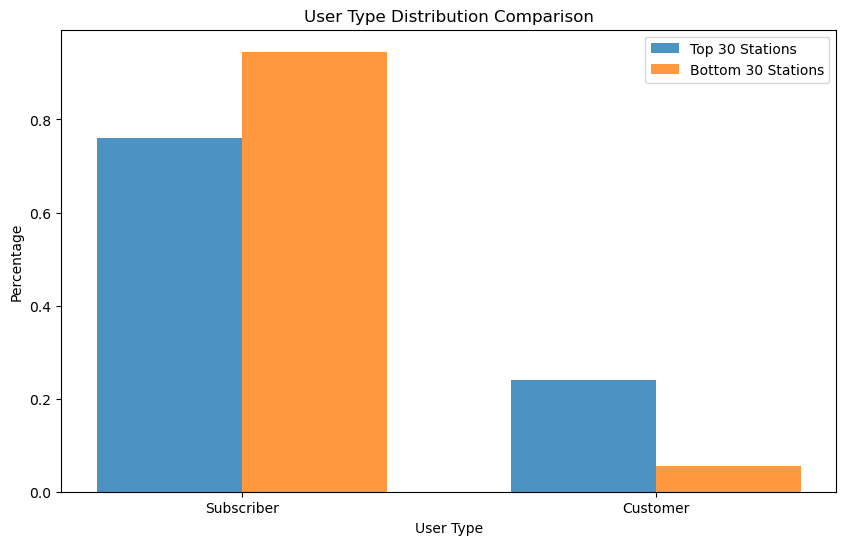

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
opacity = 0.8

top_users_counts = top_users.values
bottom_users_counts = bottom_users.values

index = range(len(top_users.index))

ax.bar(index, top_users_counts, bar_width, alpha=opacity, label='Top 30 Stations')
ax.bar([x + bar_width for x in index], bottom_users_counts, bar_width, alpha=opacity, label='Bottom 30 Stations')

ax.set_xlabel('User Type')
ax.set_ylabel('Percentage')
ax.set_title('User Type Distribution Comparison')
ax.set_xticks([x + bar_width/2 for x in index])
ax.set_xticklabels(top_users.index)
ax.legend()

plt.show()

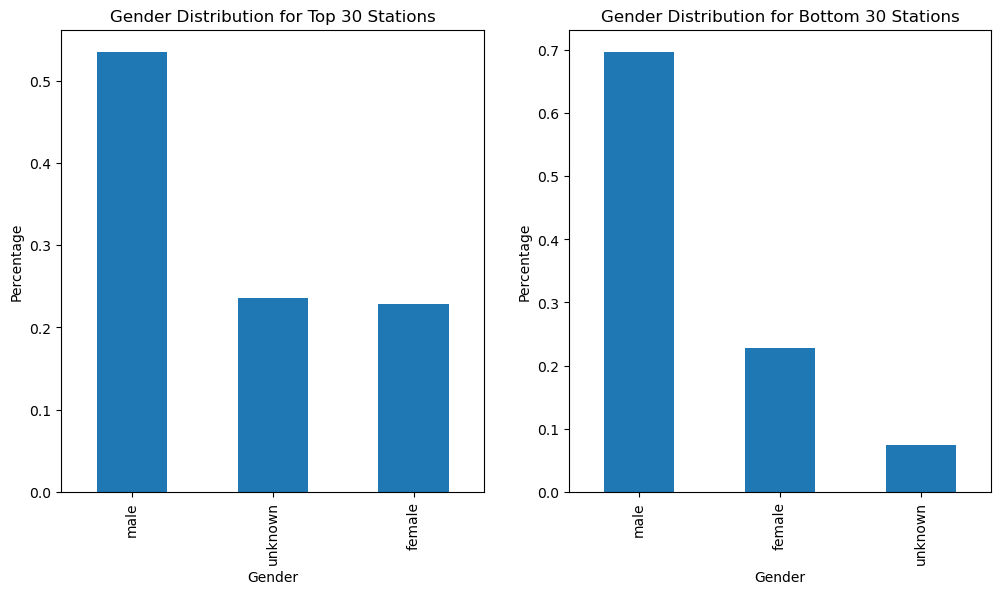

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

top_gender.plot(kind='bar', ax=ax1)
ax1.set_title('Gender Distribution for Top 30 Stations')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Percentage')

bottom_gender.plot(kind='bar', ax=ax2)
ax2.set_title('Gender Distribution for Bottom 30 Stations')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Percentage')

plt.show()

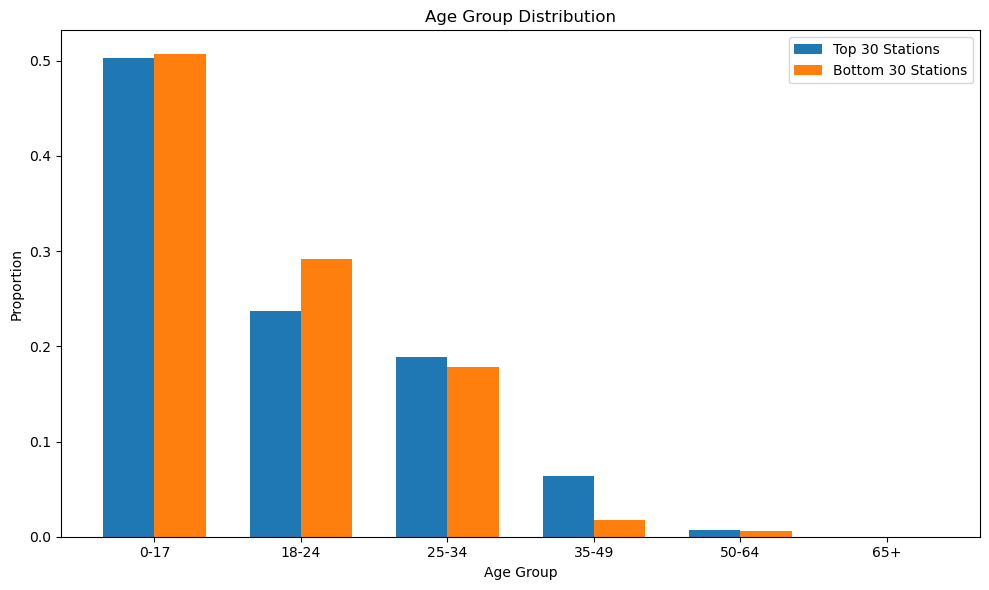

In [52]:
top_stations_data.loc[:, 'age'] = 2023 - top_stations_data['birth_year']
bottom_stations_data.loc[:, 'age'] = 2023 - bottom_stations_data['birth_year']

age_bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['0-17', '18-24', '25-34', '35-49', '50-64', '65+']

top_age_groups = pd.cut(top_stations_data['age'], bins=age_bins, labels=labels, right=False).value_counts(normalize=True)
bottom_age_groups = pd.cut(bottom_stations_data['age'], bins=age_bins, labels=labels, right=False).value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
x = np.arange(len(labels))

ax.bar(x, top_age_groups, bar_width, label='Top 30 Stations')
ax.bar(x + bar_width, bottom_age_groups, bar_width, label='Bottom 30 Stations')

ax.set_title('Age Group Distribution')
ax.set_xlabel('Age Group')
ax.set_ylabel('Proportion')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

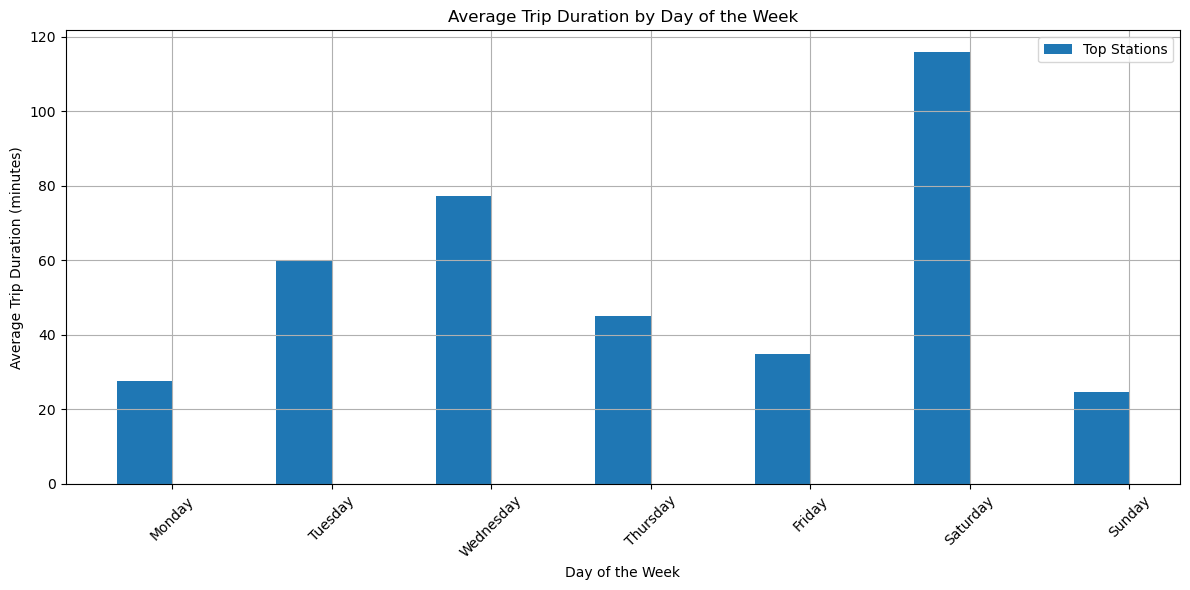

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))

top_stations_data.loc[:, 'day_of_week'] = top_stations_data.index.day_name()


bar_width = 0.35
x = np.arange(len(top_stations_data['day_of_week'].unique()))


top_data = top_stations_data.groupby('day_of_week')['tripduration'].mean() / 60
ax.bar(x - bar_width/2, top_data.values, width=bar_width, label='Top Stations')


ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Trip Duration (minutes)')
ax.set_title('Average Trip Duration by Day of the Week')
ax.set_xticks(x)
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

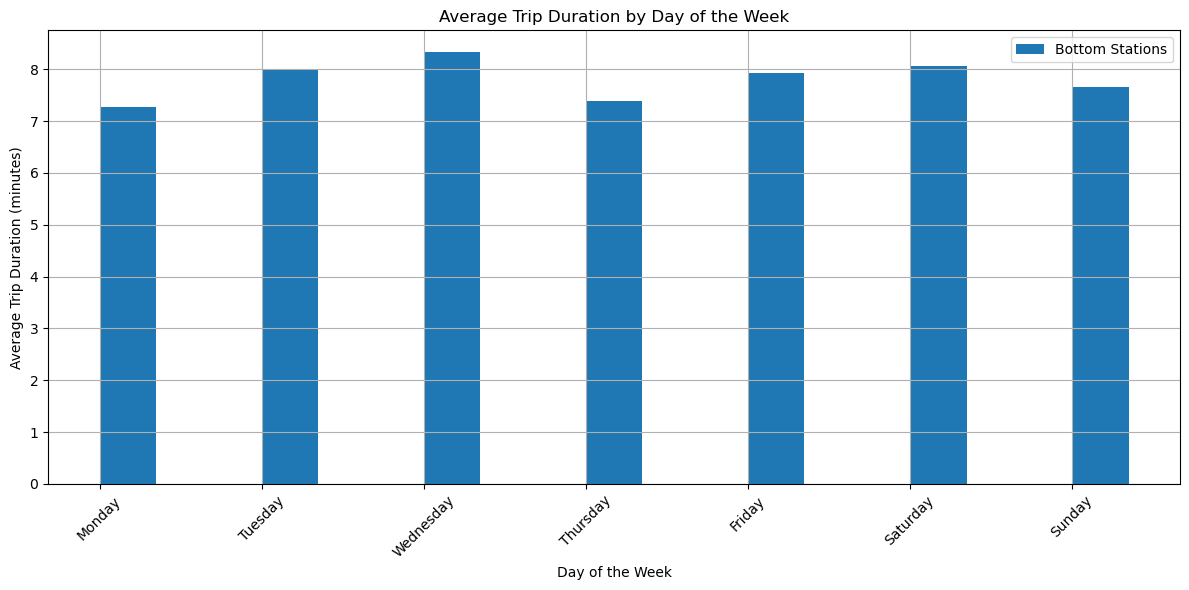

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

bottom_stations_data.loc[:, 'day_of_week'] = bottom_stations_data.index.day_name()

bar_width = 0.35
m = np.arange(len(bottom_stations_data['day_of_week'].unique()))

bottom_data = bottom_stations_data.groupby('day_of_week')['tripduration'].mean() / 60
ax.bar(m + bar_width/2, bottom_data.values, width=bar_width, label='Bottom Stations')


ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Trip Duration (minutes)')
ax.set_title('Average Trip Duration by Day of the Week')
ax.set_xticks(m)
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()